# Random Number Generation Experiments


![RNG diagram](../rng.png)


## Introduction

This notebook sets up experiments comparing different methods for training language models to generate random numbers from specified distributions.

We will focus on sampling numbers from various distributions.

The models we will compare are:

- GFN-fine-tuned LM: Fine-tuned via generative flow networks
- Likelihood-trained LM: Supervised-fine-tuned LM
- RL-tuned LM: Fine-tuned via reinforcement learning (PPO)


Several axes of experimentation:

- vary the distribution
  - discrete: uniform, Poisson, Binomial, Geometric, etc
  - continuous: uniform, Gaussian, exponential, etc
- vary the hyperparameters of the distribution (in the context)
  - Uniform: between 0 and `n_max`
  - Poisson: `lambda` between `λ_min` and `λ_max`
  - etc
- vary the prompt
  - 'Randomly generate (uniformly) one single random integer between 0 and {num_test}, and then stop: '
  - 'Randomly generate (uniformly) one single random integer in the interval [0, {num_test}]: '
  - 'Here is one single random integer sampled uniformly between 0 and {num_test}: '
  - "The following is a random integer drawn uniformly between 0 and {num_test}: "
  - etc
- vary the model
  - GFN-LM
  - PPO
  - MLE (SFT)


## General imports


In [1]:
import os
import sys
import hydra
from hydra.experimental import initialize, compose
import wandb

In [2]:
if (
    not os.path.exists("gfn-lm-tuning")
    and os.path.basename(os.getcwd()) != "gfn-lm-tuning"
):
    !git clone https://github.com/GFNOrg/gfn-lm-tuning
    %cd gfn-lm-tuning
elif os.path.basename(os.getcwd()) != "gfn-lm-tuning":
    %cd gfn-lm-tuning
else:
    !git pull

/home/mila/y/younesse.kaddar/gfn-lm-tuning


In [3]:
import random
import numpy as np
from tqdm import tqdm
import pandas as pd

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import torch.nn.functional as F
from peft import LoraConfig, get_peft_model, PeftModel

from rng.rng_utils import generate, generate_and_return_eos_logprob

[2024-01-11 06:26:47,599] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [4]:
print(os.getenv("HF_HOME"))

/network/scratch/y/younesse.kaddar/huggingface


In [5]:
import matplotlib
import matplotlib.font_manager
import matplotlib.pyplot as plt
import shutil

import seaborn as sns
from IPython.display import display, Markdown

# # Remove the matplotlib cache
# shutil.rmtree(matplotlib.get_cachedir())

fonts = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext="ttf")

# print the names of all fonts
font_names = [matplotlib.font_manager.get_font(x).family_name for x in fonts]
print(font_names)

fonts = [f.name for f in matplotlib.font_manager.fontManager.ttflist]
print(fonts)
print("Times New Roman" in fonts)

plt.rcParams["font.family"] = "Times New Roman"
matplotlib.rc("font", family="Times New Roman")

print(matplotlib.get_configdir())
print(matplotlib.get_cachedir())

['DejaVu Sans Mono', 'DejaVu Serif', 'DejaVu Sans Mono', 'DejaVu Sans', 'DejaVu Serif', 'Times New Roman', 'DejaVu Sans']
['DejaVu Sans Mono', 'DejaVu Serif', 'STIXSizeFourSym', 'STIXNonUnicode', 'STIXSizeThreeSym', 'DejaVu Serif', 'cmss10', 'STIXNonUnicode', 'STIXSizeThreeSym', 'STIXSizeTwoSym', 'STIXNonUnicode', 'cmsy10', 'STIXGeneral', 'DejaVu Sans', 'cmmi10', 'DejaVu Sans Mono', 'DejaVu Sans Display', 'STIXSizeFourSym', 'DejaVu Sans Mono', 'STIXGeneral', 'DejaVu Sans', 'DejaVu Serif', 'DejaVu Serif', 'cmr10', 'STIXNonUnicode', 'STIXGeneral', 'cmb10', 'Times New Roman', 'DejaVu Sans Mono', 'STIXSizeOneSym', 'STIXSizeOneSym', 'STIXGeneral', 'cmex10', 'DejaVu Serif Display', 'STIXSizeTwoSym', 'DejaVu Sans', 'cmtt10', 'DejaVu Sans', 'STIXSizeFiveSym', 'DejaVu Sans', 'DejaVu Serif', 'DejaVu Sans', 'DejaVu Sans Mono', 'Times New Roman', 'DejaVu Sans Mono', 'DejaVu Serif']
True
/home/mila/y/younesse.kaddar/.config/matplotlib
/home/mila/y/younesse.kaddar/.cache/matplotlib


In [6]:
%load_ext autoreload
%autoreload 2
!pwd

/home/mila/y/younesse.kaddar/gfn-lm-tuning


In [7]:
!nvidia-smi

Thu Jan 11 06:26:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:B7:00.0 Off |                    0 |
| N/A   32C    P0              64W / 400W |      7MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [8]:
import gc

with torch.no_grad():
    gc.collect()
    torch.cuda.empty_cache()

In [9]:
!wandb login

wandb: Currently logged in as: youkad (ox). Use `wandb login --relogin` to force relogin


# Load the pretrained model


In [10]:
# Initialize Hydra
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(config_path="gfn-lm-tuning/rng/configs")
cfg = compose(config_name="config")

bsz = cfg.hparams.GFN.bsz
grad_acc = cfg.hparams.grad_acc
lr = cfg.hparams.lr
warmup_steps = cfg.hparams.warmup_steps
subtb_lambda = cfg.hparams.GFN.subtb_lambda
max_len = cfg.hparams.max_len
min_len = cfg.hparams.min_len
eval_interval = cfg.hparams.eval_interval
log_interval = cfg.hparams.log_interval
model_to_use = cfg.hparams.model_to_use
seed = cfg.hparams.seed
save_dir = cfg.hparams.save_dir
epochs = 10  # cfg.hparams.epochs

/home/mila/y/younesse.kaddar/virtualenvs/lm_3.10/lib/python3.10/site-packages/hydra/experimental/initialize.py:43: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  deprecation_warning(message=message)
/home/mila/y/younesse.kaddar/virtualenvs/lm_3.10/lib/python3.10/site-packages/hydra/experimental/initialize.py:45: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  self.delegate = real_initialize(
/home/mila/y/younesse.kaddar/virtualenvs/lm_3.10/lib/python3.10/site-packages/hydra/experimental/compose.py:25: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  deprecation_warning(message=message)


In [11]:
# Set the seed
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [12]:
if model_to_use == "gpt-j":
    tokenizer = AutoTokenizer.from_pretrained("nlpcloud/instruct-gpt-j-fp16")
    model = AutoModelForCausalLM.from_pretrained(
        "nlpcloud/instruct-gpt-j-fp16", torch_dtype=torch.bfloat16
    )
elif model_to_use == "gpt2":
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    model = AutoModelForCausalLM.from_pretrained("gpt2")

model.to("cuda")

GPTJForCausalLM(
  (transformer): GPTJModel(
    (wte): Embedding(50400, 4096)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-27): 28 x GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (out_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): GPTJMLP(
          (fc_in): Linear(in_features=4096, out_features=16384, bias=True)
          (fc_out): Linear(in_features=16384, out_features=4096, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f)

# Training


## LoRA, Optimizer


In [13]:
lora_config = LoraConfig(
    r=cfg.lora.r,
    lora_alpha=cfg.lora.lora_alpha,
    target_modules=["k_proj", "v_proj"] if model_to_use == "gpt-j" else ["c_attn"],
    lora_dropout=cfg.lora.lora_dropout,
    bias=cfg.lora.bias,
)
inference_model = get_peft_model(model, lora_config)

opt = torch.optim.AdamW(
    [{"params": inference_model.parameters(), "lr": lr}],
    betas=(cfg.adamw.b1, cfg.adamw.b2),
)

## Dataloader and Scheduler


In [14]:
from rng.data_generator import main as generate_data

if not os.path.exists(cfg.file_name.train):
    generate_data(cfg)

In [15]:
from rng.rng_dataset import get_dataloader_from_dataframe

df_train = pd.read_csv(cfg.file_name.train)

train_loader = get_dataloader_from_dataframe(df_train, tokenizer, bsz=bsz, shuffle=True)

Tokenizing dataset...: 2048it [00:00, 5480.86it/s]


In [16]:
list(train_loader)[0]

[tensor([[  464,  1708,   318,   257,  4738, 18253,  7428, 42096,  1022,   657,
            290,  1802,    25,   220],
         [  464,  1708,   318,   257,  4738, 18253,  7428, 42096,  1022,   657,
            290,  1802,    25,   220],
         [  464,  1708,   318,   257,  4738, 18253,  7428, 42096,  1022,   657,
            290,  1802,    25,   220],
         [  464,  1708,   318,   257,  4738, 18253,  7428, 42096,  1022,   657,
            290,  1802,    25,   220],
         [  464,  1708,   318,   257,  4738, 18253,  7428, 42096,  1022,   657,
            290,  1802,    25,   220],
         [  464,  1708,   318,   257,  4738, 18253,  7428, 42096,  1022,   657,
            290,  1802,    25,   220],
         [  464,  1708,   318,   257,  4738, 18253,  7428, 42096,  1022,   657,
            290,  1802,    25,   220],
         [  464,  1708,   318,   257,  4738, 18253,  7428, 42096,  1022,   657,
            290,  1802,    25,   220]], device='cuda:0'),
 tensor([[0],
         [0],
 

In [17]:
total_steps = epochs * len(train_loader)


# learning rate schedule
def get_lr_mult_at_step(step):
    if step <= warmup_steps:
        return step / warmup_steps
    return max((total_steps - step) / (total_steps - warmup_steps), 0)


sched = torch.optim.lr_scheduler.LambdaLR(opt, get_lr_mult_at_step)

## Tests


In [18]:
num_test = 10
print("Tokenized num_test: ", tokenizer.encode(str(num_test)), "\n\n")


def test_prompt(prompt_test, num_test=num_test):
    tokenzed_prompt_test = tokenizer(prompt_test, return_tensors="pt").to("cuda")
    print(
        f"Tokenized prompt '{prompt_test}': \n\t",
        "|".join(
            tokenizer.decode(t) for t in tokenzed_prompt_test["input_ids"].tolist()[0]
        ),
        "\n\t",
        tokenzed_prompt_test["input_ids"].tolist()[0],
        "\n\t",
        "\t ⟶ Contains tokenized `num_test`? ",
        num_test in tokenzed_prompt_test["input_ids"].tolist()[0],
        "\n",
        "Model response: \n\t",
        [
            tokenizer.decode(t)
            for t in model.generate(
                **tokenzed_prompt_test,
                max_new_tokens=30,
                temperature=0,
                pad_token_id=tokenizer.eos_token_id,
            )[0][len(tokenizer.encode(prompt_test)) :]
        ],
        "\n\n\n",
    )


prompt_tests = [
    f"Randomly generate (uniformly) one single random integer between 0 and {num_test}, and then stop: ",
    f"Randomly generate (uniformly) one single random integer in the interval [0, {num_test}]: ",
    f"Here is one single random integer sampled uniformly between 0 and {num_test}: ",
    f"The following is a random integer drawn uniformly between 0 and {num_test}: ",
]

for prompt_test in prompt_tests:
    test_prompt(prompt_test)

Tokenized num_test:  [940] 


Tokenized prompt 'Randomly generate (uniformly) one single random integer between 0 and 10, and then stop: ': 
	 Random|ly| generate| (|un|iform|ly|)| one| single| random| integer| between| 0| and| 10|,| and| then| stop|:|  
	 [29531, 306, 7716, 357, 403, 6933, 306, 8, 530, 2060, 4738, 18253, 1022, 657, 290, 838, 11, 290, 788, 2245, 25, 220] 
	 	 ⟶ Contains tokenized `num_test`?  False 
 Model response: 
	 [' the', ' number', ' you', ' generated', '.', '\n', '<|endoftext|>'] 



Tokenized prompt 'Randomly generate (uniformly) one single random integer in the interval [0, 10]: ': 
	 Random|ly| generate| (|un|iform|ly|)| one| single| random| integer| in| the| interval| [|0|,| 10|]:|  
	 [29531, 306, 7716, 357, 403, 6933, 306, 8, 530, 2060, 4738, 18253, 287, 262, 16654, 685, 15, 11, 838, 5974, 220] 
	 	 ⟶ Contains tokenized `num_test`?  False 
 Model response: 
	 [' \\', 'n', '\\', 'n', 'The', ' randomly', ' generated', ' integer', ' is', ':', ' 8', '\n', '<|

In [19]:
numbers = range(1, 1001)

num_more_than_one_token = (
    (num, tokens) for num in numbers if len(tokens := tokenizer.encode(str(num))) > 1
)

first_number_more_than_one, first_number_more_than_one_token = next(
    num_more_than_one_token
)
print(
    f"The first number that requires more than 1 token is: {first_number_more_than_one, first_number_more_than_one_token}"
)
print(
    f"The second number that requires more than 1 token is: {next(num_more_than_one_token)}"
)
print(
    f"The third number that requires more than 1 token is: {next(num_more_than_one_token)}"
)

The first number that requires more than 1 token is: (521, [20, 2481])
The second number that requires more than 1 token is: (527, [20, 1983])
The third number that requires more than 1 token is: (531, [20, 3132])


In [20]:
num_tokens = [tokenizer.encode(str(num)) for num in range(first_number_more_than_one)]

allowed_indices = torch.tensor(
    [token for sublist in num_tokens for token in sublist], device="cuda"
)

vocab_nice_list = torch.zeros(len(tokenizer.vocab), device="cuda").bool()
vocab_nice_list[allowed_indices] = True
vocab_nice_list[tokenizer.eos_token_id] = True
len(vocab_nice_list)

50400

In [21]:
n_max = cfg.distributions["uniform discrete"].parameters.b
eos_token_id = tokenizer.eos_token_id
eos_string = tokenizer.decode(eos_token_id)
tokens_of_numbers = (
    torch.tensor([tokenizer.encode(str(num)) for num in range(n_max)]).view(-1).cuda()
)

## Training loop


In [22]:
wandb.init(project="gfn-finetuning")
# columns = ["Epoch", "Step", "Input prompt", "Response", "Reward"]
# examples_generation_table = wandb.Table(columns=columns)

# Log hyperparameters
wandb.config.bsz = bsz
wandb.config.grad_acc = grad_acc
wandb.config.lr = lr
wandb.config.warmup_steps = warmup_steps
wandb.config.subtb_lambda = subtb_lambda
wandb.config.max_len = max_len
wandb.config.min_len = min_len
wandb.config.eval_interval = eval_interval
wandb.config.log_interval = log_interval
wandb.config.model_to_use = model_to_use
wandb.config.seed = seed
wandb.config.save_dir = save_dir
wandb.config.epochs = epochs


@torch.inference_mode()
def reward_fn(x, n_max=n_max, skip_first=1):
    # Get the token ids after skip_first
    token_ids = x[:, skip_first:]

    if token_ids.shape[1] == 0:
        return torch.full((x.shape[0],), fill_value=-8).cuda()

    # Initialize rewards to a low value
    rew = torch.full(token_ids.shape, fill_value=-8).cuda() * torch.arange(
        1, token_ids.shape[1] + 1, device="cuda"
    )

    # Create a mask where the first token is in the list of tokenized permitted numbers
    tokenized_permitted_numbers_mask = tokens_of_numbers[:n_max]
    first_token_mask = torch.cat(
        (
            (token_ids[:, 0].unsqueeze(-1) == tokenized_permitted_numbers_mask)
            .any(dim=-1)
            .unsqueeze(-1),
            torch.zeros(
                token_ids.shape[0], token_ids.shape[1] - 1, device="cuda"
            ).bool(),
        ),
        dim=-1,
    )

    # Create a mask where the remaining tokens are the eos_token_id
    remaining_eos_tokens_mask = torch.cat(
        (
            torch.zeros(token_ids.shape[0], 1, device="cuda").bool(),
            token_ids[:, 1:] == eos_token_id,
        ),
        dim=-1,
    )

    # Set the reward to 8 (resp. 0) where
    # the token is the first token and in the list of tokenized permitted numbers,
    # (resp. it is one of the remaining tokens and equal to eos_token_id)
    rew[first_token_mask] = 8
    rew[remaining_eos_tokens_mask] = 0

    # return torch.cat((res[:, :1], res), dim=-1)
    # return torch.cat((rew, rew.new_full((rew.shape[0], 1), 0)), dim=-1).cumsum(dim=-1)
    return rew.sum(dim=-1)


inference_model.train()
for epoch in tqdm(range(epochs), desc="Epochs"):
    for step, batch in tqdm(
        enumerate(train_loader), desc=f"Epoch {epoch}", total=len(train_loader)
    ):
        opt.zero_grad()
        loss = 0.0
        for _ in range(grad_acc):
            encoded_input, _ = batch
            (
                generated_text,
                logPF,
                eos_logprob,
                logrewards,
            ) = generate_and_return_eos_logprob(
                inference_model,
                encoded_input,
                eos_token_id=eos_token_id,
                reward_fn=lambda x: reward_fn(
                    x, n_max=n_max, skip_first=encoded_input.size(-1)
                ),
                # vocab_nice_mask=vocab_nice_list,
                max_len=max_len,
                min_len=min_len,
                temperature=1,
            )

            # modified subTB loss with logpb=0
            delta = (
                logrewards[:, :-1]
                - eos_logprob[:, :-1]
                + logPF[:, :-1]
                - (logrewards[:, 1:] - eos_logprob[:, 1:])
            )
            delta_cumsum = torch.cat([torch.zeros_like(delta[:, :1]), delta], 1).cumsum(
                1
            )

            # get a mask for tokens after the first eos in generated_text
            mask = (generated_text == eos_token_id).cumsum(dim=-1) >= 1
            mask = mask[:, encoded_input.size(-1) :]
            mask = mask[:, :max_len]
            # if mask is too short, pad it
            if mask.size(-1) < max_len:
                mask = torch.cat(
                    [
                        mask,
                        torch.ones(
                            mask.size(0),
                            max_len - mask.size(-1),
                            dtype=torch.bool,
                            device="cuda",
                        ),
                    ],
                    dim=-1,
                )
            # get trajectory lengths by summing the mask
            batch_loss = 0.0
            total_lambda = 0.0
            for subtraj_len in range(1, max_len + 1):
                subtb_term = (
                    delta_cumsum[:, subtraj_len:] - delta_cumsum[:, :-subtraj_len]
                ) ** 2
                subtb_term[mask[:, subtraj_len - 1 :]] = 0
                batch_loss += subtb_lambda ** (subtraj_len - 1) * subtb_term.sum()
                total_lambda += (
                    subtb_lambda ** (subtraj_len - 1)
                    * (~mask[:, subtraj_len - 1 :]).sum()
                )
            batch_loss /= total_lambda

            loss += batch_loss.mean()
            batch_loss.mean().backward()
            wandb.log({"loss": loss.item()})
        opt.step()
        sched.step()
        if step % log_interval == 0:
            print(f"Epoch: {epoch}, Batch: {step}, Loss: {loss.item()}")
        for i in range(generated_text.size(0)):
            wandb.log(
                {
                    "epoch": epoch,
                    "step": step,
                    "input prompt": tokenizer.decode(
                        generated_text[i, : len(encoded_input[i])]
                    )
                    .replace(eos_string, "")
                    .rstrip(),
                    "response": tokenizer.decode(
                        generated_text[i, len(encoded_input[i]) :]
                    ),
                    "reward": reward_fn(
                        generated_text[i].unsqueeze(0), skip_first=len(encoded_input[i])
                    ).item(),
                }
            )

# wandb.log({"examples generation": examples_generation_table})
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: youkad (ox). Use `wandb login --relogin` to force relogin


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0, Batch: 0, Loss: 6230.1787109375


Epoch: 0, Batch: 10, Loss: 11.78463363647461


Epoch: 0, Batch: 20, Loss: 34.80643844604492


Epoch: 0, Batch: 30, Loss: 69.33173370361328


Epoch: 0, Batch: 40, Loss: 143.97804260253906


Epoch: 0, Batch: 50, Loss: 41.37861251831055


Epoch: 0, Batch: 60, Loss: 33.5132942199707


Epoch: 0, Batch: 70, Loss: 16.18343734741211


Epoch: 0, Batch: 80, Loss: 8.318410873413086


Epoch: 0, Batch: 90, Loss: 35.71435546875


Epoch: 0, Batch: 100, Loss: 58.62720489501953


Epoch: 0, Batch: 110, Loss: 85.02554321289062


Epoch: 0, Batch: 120, Loss: 24.97364044189453


Epoch: 0, Batch: 130, Loss: 5.901442527770996


Epoch: 0, Batch: 140, Loss: 2.912597179412842


Epoch: 0, Batch: 150, Loss: 2.722351312637329


Epoch: 0, Batch: 160, Loss: 2.240706443786621


Epoch: 0, Batch: 170, Loss: 5.166847229003906


Epoch: 0, Batch: 180, Loss: 2.1255035400390625


Epoch: 0, Batch: 190, Loss: 1.490882396697998


Epoch: 0, Batch: 200, Loss: 1.045379400253296


Epoch: 0, Batch: 210, Loss: 0.9690625071525574


Epoch: 0, Batch: 220, Loss: 1.6126788854599


Epoch: 0, Batch: 230, Loss: 0.6549379229545593


Epoch: 0, Batch: 240, Loss: 0.6265485286712646


Epoch: 0, Batch: 250, Loss: 0.37632036209106445


Epochs:  10%|█         | 1/10 [12:58<1:56:50, 778.94s/it]

Epoch: 1, Batch: 0, Loss: 0.2669980823993683


Epoch: 1, Batch: 10, Loss: 0.8761524558067322


Epoch: 1, Batch: 20, Loss: 0.23358139395713806


Epoch: 1, Batch: 30, Loss: 0.1833423376083374


Epoch: 1, Batch: 40, Loss: 0.3469998836517334


Epoch: 1, Batch: 50, Loss: 1.1760562658309937


Epoch: 1, Batch: 60, Loss: 0.3220673203468323


Epoch: 1, Batch: 70, Loss: 0.14217351377010345


Epoch: 1, Batch: 80, Loss: 0.17709338665008545


Epoch: 1, Batch: 90, Loss: 0.11983474344015121


Epoch: 1, Batch: 100, Loss: 0.12536637485027313


Epoch: 1, Batch: 110, Loss: 0.09570322185754776


Epoch: 1, Batch: 120, Loss: 0.22849273681640625


Epoch: 1, Batch: 130, Loss: 0.10231001675128937


Epoch: 1, Batch: 140, Loss: 0.06587214767932892


Epoch: 1, Batch: 150, Loss: 0.17898568511009216


Epoch: 1, Batch: 160, Loss: 0.3071748614311218


Epoch: 1, Batch: 170, Loss: 0.10619357228279114


Epoch: 1, Batch: 180, Loss: 0.07843011617660522


Epoch: 1, Batch: 190, Loss: 0.2320024073123932


Epoch: 1, Batch: 200, Loss: 0.06053910031914711


Epoch: 1, Batch: 210, Loss: 0.08960716426372528


Epoch: 1, Batch: 220, Loss: 0.08293896168470383


Epoch: 1, Batch: 230, Loss: 6.710533142089844


Epoch: 1, Batch: 240, Loss: 0.14586642384529114


Epoch: 1, Batch: 250, Loss: 0.0882490798830986


Epochs:  20%|██        | 2/10 [25:31<1:41:47, 763.49s/it]

Epoch: 2, Batch: 0, Loss: 0.06054697558283806


Epoch: 2, Batch: 10, Loss: 0.045227061957120895


Epoch: 2, Batch: 20, Loss: 0.09139244258403778


Epoch: 2, Batch: 30, Loss: 0.04284666106104851


Epoch: 2, Batch: 40, Loss: 0.0504378043115139


Epoch: 2, Batch: 50, Loss: 0.04016869142651558


Epoch: 2, Batch: 60, Loss: 0.3251040577888489


Epoch: 2, Batch: 70, Loss: 0.02870946377515793


Epoch: 2, Batch: 80, Loss: 0.06927493214607239


Epoch: 2, Batch: 90, Loss: 0.041885439306497574


Epoch: 2, Batch: 100, Loss: 0.04227449744939804


Epoch: 2, Batch: 110, Loss: 0.031120341271162033


Epoch: 2, Batch: 120, Loss: 0.032409630715847015


Epoch: 2, Batch: 130, Loss: 0.04928583651781082


Epoch: 2, Batch: 140, Loss: 0.02553551271557808


Epoch: 2, Batch: 150, Loss: 5.9349517822265625


Epoch: 2, Batch: 160, Loss: 0.06841293722391129


Epoch: 2, Batch: 170, Loss: 0.20218652486801147


Epoch: 2, Batch: 180, Loss: 0.11794479191303253


Epoch: 2, Batch: 190, Loss: 0.04082486033439636


Epoch: 2, Batch: 200, Loss: 0.07395358383655548


Epoch: 2, Batch: 210, Loss: 5.867095947265625


Epoch: 2, Batch: 220, Loss: 0.06044779717922211


Epoch: 2, Batch: 230, Loss: 0.04605873301625252


Epoch: 2, Batch: 240, Loss: 0.05233775079250336


Epoch: 2, Batch: 250, Loss: 0.028999386355280876


Epochs:  30%|███       | 3/10 [38:04<1:28:31, 758.80s/it]

Epoch: 3, Batch: 0, Loss: 0.03440093249082565


Epoch: 3, Batch: 10, Loss: 0.045989990234375


Epoch: 3, Batch: 20, Loss: 0.04975897818803787


Epoch: 3, Batch: 30, Loss: 0.025215089321136475


Epoch: 3, Batch: 40, Loss: 0.027626095339655876


Epoch: 3, Batch: 50, Loss: 0.04326820746064186


Epoch: 3, Batch: 60, Loss: 0.04175375774502754


Epoch: 3, Batch: 70, Loss: 0.030523300170898438


Epoch: 3, Batch: 80, Loss: 0.09482772648334503


Epoch: 3, Batch: 90, Loss: 0.0920410230755806


Epoch: 3, Batch: 100, Loss: 0.07019031047821045


Epoch: 3, Batch: 110, Loss: 0.04321286827325821


Epoch: 3, Batch: 120, Loss: 0.03516373038291931


Epoch: 3, Batch: 130, Loss: 0.045516982674598694


Epoch: 3, Batch: 140, Loss: 8.022012710571289


Epoch: 3, Batch: 150, Loss: 0.04090317338705063


Epoch: 3, Batch: 160, Loss: 0.03633127734065056


Epoch: 3, Batch: 170, Loss: 0.10425183176994324


Epoch: 3, Batch: 180, Loss: 0.052324190735816956


Epoch: 3, Batch: 190, Loss: 0.06602280586957932


Epoch: 3, Batch: 200, Loss: 0.03584081307053566


Epoch: 3, Batch: 210, Loss: 0.034614548087120056


Epoch: 3, Batch: 220, Loss: 0.031831707805395126


Epoch: 3, Batch: 230, Loss: 0.056655898690223694


Epoch: 3, Batch: 240, Loss: 0.02701946161687374


Epoch: 3, Batch: 250, Loss: 0.030881870537996292


Epochs:  40%|████      | 4/10 [50:38<1:15:39, 756.65s/it]

Epoch: 4, Batch: 0, Loss: 0.026893585920333862


Epoch: 4, Batch: 10, Loss: 0.05426780879497528


Epoch: 4, Batch: 20, Loss: 0.04212955757975578


Epoch: 4, Batch: 30, Loss: 0.03518110141158104


Epoch: 4, Batch: 40, Loss: 0.037889476865530014


Epoch: 4, Batch: 50, Loss: 0.03129385784268379


Epoch: 4, Batch: 60, Loss: 0.030271418392658234


Epoch: 4, Batch: 70, Loss: 0.07959383726119995


Epoch: 4, Batch: 80, Loss: 0.048372454941272736


Epoch: 4, Batch: 90, Loss: 0.033884014934301376


Epoch: 4, Batch: 100, Loss: 0.04183970019221306


Epoch: 4, Batch: 110, Loss: 0.03271859884262085


Epoch: 4, Batch: 120, Loss: 0.027565056458115578


Epoch: 4, Batch: 130, Loss: 0.025943852961063385


Epoch: 4, Batch: 140, Loss: 0.025688203051686287


Epoch: 4, Batch: 150, Loss: 0.02344314195215702


Epoch: 4, Batch: 160, Loss: 0.039455316960811615


Epoch: 4, Batch: 170, Loss: 0.03349505737423897


Epoch: 4, Batch: 180, Loss: 0.01780129224061966


Epoch: 4, Batch: 190, Loss: 0.02690887823700905


Epoch: 4, Batch: 200, Loss: 0.022108130156993866


Epoch: 4, Batch: 210, Loss: 0.02875894494354725


Epoch: 4, Batch: 220, Loss: 0.026912640780210495


Epoch: 4, Batch: 230, Loss: 0.03045271523296833


Epoch: 4, Batch: 240, Loss: 0.023954493924975395


Epoch: 4, Batch: 250, Loss: 0.03594204783439636


Epochs:  50%|█████     | 5/10 [1:03:07<1:02:50, 754.11s/it]

Epoch: 5, Batch: 0, Loss: 0.026758184656500816


Epoch: 5, Batch: 10, Loss: 0.019985217601060867


Epoch: 5, Batch: 20, Loss: 0.029210906475782394


Epoch: 5, Batch: 30, Loss: 0.030710270628333092


Epoch: 5, Batch: 40, Loss: 0.026609446853399277


Epoch: 5, Batch: 50, Loss: 0.020458213984966278


Epoch: 5, Batch: 60, Loss: 0.021440545096993446


Epoch: 5, Batch: 70, Loss: 0.02528185024857521


Epoch: 5, Batch: 80, Loss: 0.02593989484012127


Epoch: 5, Batch: 90, Loss: 0.02915767952799797


Epoch: 5, Batch: 100, Loss: 0.02089111879467964


Epoch: 5, Batch: 110, Loss: 0.027894916012883186


Epoch: 5, Batch: 120, Loss: 0.024290116503834724


Epoch: 5, Batch: 130, Loss: 0.02171909809112549


Epoch: 5, Batch: 140, Loss: 0.03329266607761383


Epoch: 5, Batch: 150, Loss: 0.02253527194261551


Epoch: 5, Batch: 160, Loss: 0.03207598626613617


Epoch: 5, Batch: 170, Loss: 0.026113413274288177


Epoch: 5, Batch: 180, Loss: 0.022287340834736824


Epoch: 5, Batch: 190, Loss: 0.022699398919939995


Epoch: 5, Batch: 200, Loss: 0.018842648714780807


Epoch: 5, Batch: 210, Loss: 0.022436197847127914


Epoch: 5, Batch: 220, Loss: 0.02171708270907402


Epoch: 5, Batch: 230, Loss: 0.029924359172582626


Epoch: 5, Batch: 240, Loss: 0.012989002279937267


Epoch: 5, Batch: 250, Loss: 0.020118827000260353


Epochs:  60%|██████    | 6/10 [1:15:38<50:11, 752.89s/it]  

Epoch: 6, Batch: 0, Loss: 0.018514560535550117


Epoch: 6, Batch: 10, Loss: 0.02333824336528778


Epoch: 6, Batch: 20, Loss: 0.023359322920441628


Epoch: 6, Batch: 30, Loss: 0.0188312828540802


Epoch: 6, Batch: 40, Loss: 0.02430729568004608


Epoch: 6, Batch: 50, Loss: 0.020450638607144356


Epoch: 6, Batch: 60, Loss: 0.01936156116425991


Epoch: 6, Batch: 70, Loss: 0.02322007343173027


Epoch: 6, Batch: 80, Loss: 0.017574258148670197


Epoch: 6, Batch: 90, Loss: 0.018215090036392212


Epoch: 6, Batch: 100, Loss: 0.02707669883966446


Epoch: 6, Batch: 110, Loss: 0.017042189836502075


Epoch: 6, Batch: 120, Loss: 0.028848636895418167


Epoch: 6, Batch: 130, Loss: 0.02607150189578533


Epoch: 6, Batch: 140, Loss: 0.02700040489435196


Epoch: 6, Batch: 150, Loss: 0.01956547610461712


Epoch: 6, Batch: 160, Loss: 0.03487405925989151


Epoch: 6, Batch: 170, Loss: 0.019073642790317535


Epoch: 6, Batch: 180, Loss: 0.018331505358219147


Epoch: 6, Batch: 190, Loss: 0.024804959073662758


Epoch: 6, Batch: 200, Loss: 0.017019296064972878


Epoch: 6, Batch: 210, Loss: 0.021409975364804268


Epoch: 6, Batch: 220, Loss: 0.015806253999471664


Epoch: 6, Batch: 230, Loss: 0.024362511932849884


Epoch: 6, Batch: 240, Loss: 0.022066166624426842


Epoch: 6, Batch: 250, Loss: 0.015960656106472015


Epochs:  70%|███████   | 7/10 [1:28:09<37:37, 752.42s/it]

Epoch: 7, Batch: 0, Loss: 0.019128814339637756


Epoch: 7, Batch: 10, Loss: 0.018703393638134003


Epoch: 7, Batch: 20, Loss: 0.019617056474089622


Epoch: 7, Batch: 30, Loss: 0.02225310169160366


Epoch: 7, Batch: 40, Loss: 0.01639564149081707


Epoch: 7, Batch: 50, Loss: 0.017789870500564575


Epoch: 7, Batch: 60, Loss: 0.016021711751818657


Epoch: 7, Batch: 70, Loss: 0.024351216852664948


Epoch: 7, Batch: 80, Loss: 0.017946286126971245


Epoch: 7, Batch: 90, Loss: 0.017740236595273018


Epoch: 7, Batch: 100, Loss: 0.01110268197953701


Epoch: 7, Batch: 110, Loss: 0.045795466750860214


Epoch: 7, Batch: 120, Loss: 0.024868035688996315


Epoch: 7, Batch: 130, Loss: 0.013835946097970009


Epoch: 7, Batch: 140, Loss: 0.01808927208185196


Epoch: 7, Batch: 150, Loss: 0.028503382578492165


Epoch: 7, Batch: 160, Loss: 0.01945892721414566


Epoch: 7, Batch: 170, Loss: 0.015048988163471222


Epoch: 7, Batch: 180, Loss: 6.164791107177734


Epoch: 7, Batch: 190, Loss: 0.04002569988369942


Epoch: 7, Batch: 200, Loss: 0.030029240995645523


Epoch: 7, Batch: 210, Loss: 0.03765678033232689


Epoch: 7, Batch: 220, Loss: 0.022167259827256203


Epoch: 7, Batch: 230, Loss: 0.02702508121728897


Epoch: 7, Batch: 240, Loss: 0.02398294024169445


Epoch: 7, Batch: 250, Loss: 0.039857909083366394


Epochs:  80%|████████  | 8/10 [1:40:39<25:03, 751.65s/it]

Epoch: 8, Batch: 0, Loss: 0.0270424522459507


Epoch: 8, Batch: 10, Loss: 0.026138408109545708


Epoch: 8, Batch: 20, Loss: 0.031928934156894684


Epoch: 8, Batch: 30, Loss: 0.01921088993549347


Epoch: 8, Batch: 40, Loss: 0.022546708583831787


Epoch: 8, Batch: 50, Loss: 0.01737402379512787


Epoch: 8, Batch: 60, Loss: 0.021364178508520126


Epoch: 8, Batch: 70, Loss: 0.019061991944909096


Epoch: 8, Batch: 80, Loss: 0.02824021503329277


Epoch: 8, Batch: 90, Loss: 0.03416626900434494


Epoch: 8, Batch: 100, Loss: 0.02965928241610527


Epoch: 8, Batch: 110, Loss: 0.020790142938494682


Epoch: 8, Batch: 120, Loss: 0.019191747531294823


Epoch: 8, Batch: 130, Loss: 0.022251151502132416


Epoch: 8, Batch: 140, Loss: 0.02416228875517845


Epoch: 8, Batch: 150, Loss: 0.028200240805745125


Epoch: 8, Batch: 160, Loss: 0.019521744921803474


Epoch: 8, Batch: 170, Loss: 0.023670101538300514


Epoch: 8, Batch: 180, Loss: 0.017934706062078476


Epoch: 8, Batch: 190, Loss: 0.016359347850084305


Epoch: 8, Batch: 200, Loss: 0.03261931240558624


Epoch: 8, Batch: 210, Loss: 0.01892855390906334


Epoch: 8, Batch: 220, Loss: 0.020563123747706413


Epoch: 8, Batch: 230, Loss: 0.019285118207335472


Epoch: 8, Batch: 240, Loss: 0.027202583849430084


Epoch: 8, Batch: 250, Loss: 0.022420842200517654


Epochs:  90%|█████████ | 9/10 [1:53:10<12:31, 751.27s/it]

Epoch: 9, Batch: 0, Loss: 2.576883316040039


Epoch: 9, Batch: 10, Loss: 0.023363055661320686


Epoch: 9, Batch: 20, Loss: 0.027536382898688316


Epoch: 9, Batch: 30, Loss: 0.02492321841418743


Epoch: 9, Batch: 40, Loss: 0.024095594882965088


Epoch: 9, Batch: 50, Loss: 0.018747249618172646


Epoch: 9, Batch: 60, Loss: 2.3980350494384766


Epoch: 9, Batch: 70, Loss: 0.028306998312473297


Epoch: 9, Batch: 80, Loss: 0.020690957084298134


Epoch: 9, Batch: 90, Loss: 0.01594354584813118


Epoch: 9, Batch: 100, Loss: 0.0211334191262722


Epoch: 9, Batch: 110, Loss: 8.308328628540039


Epoch: 9, Batch: 120, Loss: 0.03135105222463608


Epoch: 9, Batch: 130, Loss: 0.020524878054857254


Epoch: 9, Batch: 140, Loss: 0.017793672159314156


Epoch: 9, Batch: 150, Loss: 0.02734176628291607


Epoch: 9, Batch: 160, Loss: 0.02032659947872162


Epoch: 9, Batch: 170, Loss: 0.021627366542816162


Epoch: 9, Batch: 180, Loss: 0.018281977623701096


Epoch: 9, Batch: 190, Loss: 0.024288227781653404


Epoch: 9, Batch: 200, Loss: 0.029895834624767303


Epoch: 9, Batch: 210, Loss: 0.02424243837594986


Epoch: 9, Batch: 220, Loss: 0.027341820299625397


Epoch: 9, Batch: 230, Loss: 0.02587895281612873


Epoch: 9, Batch: 240, Loss: 0.02973373606801033


Epoch: 9, Batch: 250, Loss: 0.02620307169854641


Epochs: 100%|██████████| 10/10 [2:05:42<00:00, 754.24s/it]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
loss,▇█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁██████████████████████████████████████
step,▁▃▅▇▁▃▅▇▁▃▅▇▁▃▅▇▁▃▅▇▁▃▅▇▁▃▅▇▁▃▅▇▁▃▅▇▁▃▅█
epoch,9
input prompt,The following is a r...
loss,0.02167
response,71<|endoftext|><|end...
reward,8
step,255


### Test generations


In [23]:
test_results = generate(
    inference_model,
    encoded_input.repeat(8, 1),
    eos_token_id=eos_token_id,
    max_len=max_len,
    temperature=1,
)[0]

for i in range(generated_text.size(0)):
    print(
        tokenizer.decode(test_results[i, : len(encoded_input[0])]),
        [tokenizer.decode(t) for t in test_results[i, len(encoded_input[0]) :]],
        "\n\t\t\t\t\t\t\t Reward:",
        reward_fn(test_results[i].unsqueeze(0), skip_first=len(encoded_input[0])),
        "\n\n",
    )

The following is a random integer drawn uniformly between 0 and 100:  ['49', '<|endoftext|>'] 
							 Reward: tensor([8], device='cuda:0') 


The following is a random integer drawn uniformly between 0 and 100:  ['96', '<|endoftext|>'] 
							 Reward: tensor([8], device='cuda:0') 


The following is a random integer drawn uniformly between 0 and 100:  ['94', '<|endoftext|>'] 
							 Reward: tensor([8], device='cuda:0') 


The following is a random integer drawn uniformly between 0 and 100:  ['32', '<|endoftext|>'] 
							 Reward: tensor([8], device='cuda:0') 


The following is a random integer drawn uniformly between 0 and 100:  ['18', '<|endoftext|>'] 
							 Reward: tensor([8], device='cuda:0') 


The following is a random integer drawn uniformly between 0 and 100:  ['24', '<|endoftext|>'] 
							 Reward: tensor([8], device='cuda:0') 


The following is a random integer drawn uniformly between 0 and 100:  ['26', '<|endoftext|>'] 
							 Reward: tensor([8], device='cuda:0') 



### Save the model


In [24]:
ckpt_name = f"rng-GFN_{model_to_use}_bsz_{bsz}_grad_acc_{grad_acc}_lr_{lr}_warmup_steps_{warmup_steps}_total_steps_{total_steps}_subtb_lambda_{subtb_lambda}_max_len_{max_len}_min_len_{min_len}_eval_interval_{eval_interval}_log_interval_{log_interval}_seed_{seed}"

os.makedirs(f"{save_dir}/{ckpt_name}", exist_ok=True)
inference_model.save_pretrained(f"{save_dir}/{ckpt_name}")

print(f"Saved model to {save_dir}/{ckpt_name}")

Saved model to ckpts/rng-GFN_gpt-j_bsz_8_grad_acc_8_lr_0.0005_warmup_steps_10_total_steps_2560_subtb_lambda_1.0_max_len_5_min_len_1_eval_interval_100_log_interval_10_seed_42


# Evaluation


In [25]:
# # ckpt_name = f"rng_{model_to_use}_bsz_{bsz}_grad_acc_{grad_acc}_lr_{lr}_warmup_steps_{warmup_steps}_total_steps_{total_steps}_subtb_lambda_{subtb_lambda}_max_len_{max_len}_min_len_{min_len}_eval_interval_{eval_interval}_log_interval_{log_interval}_seed_{seed}"

# ckpt_name = "rng_gpt-j_50samples_len5_3000steps_rewtemp5.0_seed_True"
# model_path = f"{save_dir}/{ckpt_name}"
# inference_model = PeftModel.from_pretrained(model, model_path)

In [26]:
inference_model.eval()
with torch.inference_mode():
    prompt_test = "Randomly generate (uniformly) one single random integer between 0 and 520, and then stop: "
    print(
        [
            tokenizer.decode(t)
            for t in inference_model.generate(
                **tokenizer(prompt_test, return_tensors="pt").to("cuda"),
                max_new_tokens=30,
                temperature=0,
            )[0][len(tokenizer.encode(prompt_test)) :]
        ]
    )

    prompt_test = (
        "Here is one single random integer sampled uniformly between 0 and 520: "
    )
    print(
        [
            tokenizer.decode(t)
            for t in inference_model.generate(
                **tokenizer(prompt_test, return_tensors="pt").to("cuda"),
                max_new_tokens=30,
                temperature=0,
            )[0][len(tokenizer.encode(prompt_test)) :]
        ]
    )

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['75', '<|endoftext|>']
['96', '<|endoftext|>']


In [27]:
from rng.rng_utils import get_distribution

n_max = 100
intro_prompt = f"The following is a random integer drawn uniformly between 0 and "
prompt = f"{intro_prompt}{n_max}: "

In [41]:
from rng.rng_plot import plot_distribution

n_samples = 1000 * 512

In [42]:
inference_model.eval()
inference_model.base_model.enable_adapter_layers()

dist_inference, number_of_NaNs_inference = get_distribution(
    inference_model, tokenizer, prompt, num_samples=n_samples
)

100%|██████████| 1000/1000 [14:01<00:00,  1.19it/s]


In [43]:
number_of_numbers = len(dist_inference)

print(f"{number_of_numbers} numbers, {number_of_NaNs_inference} NaNs")

512000 numbers, 0 NaNs


## GFN-finetuned Model: Distribution of generated numbers

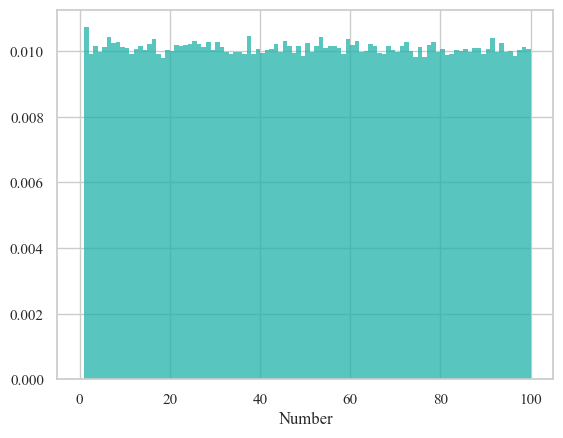

In [44]:
plot_distribution(
    dist_inference,
    n_max=n_max,
    model_name="GFN-finetuned Model",
    color="lightseagreen",
    number_of_NaNs=number_of_NaNs_inference,
    xlims=(-5, 105),
)

In [45]:
inference_model.base_model.disable_adapter_layers()

dist_vanilla, number_of_NaNs_vanilla = get_distribution(
    inference_model, tokenizer, prompt, num_samples=n_samples
)

# plot_distribution(
#     dist_vanilla,
#     model_name="Vanilla Model",
#     color="darksalmon",
#     number_of_NaNs=number_of_NaNs,
# )

100%|██████████| 1000/1000 [46:27<00:00,  2.79s/it]


In [46]:
number_of_numbers_vanilla = len(dist_vanilla)

print(f"{number_of_numbers_vanilla} numbers, {number_of_NaNs_vanilla} NaNs")

498561 numbers, 13439 NaNs


## Vanilla Model: Distribution of generated numbers

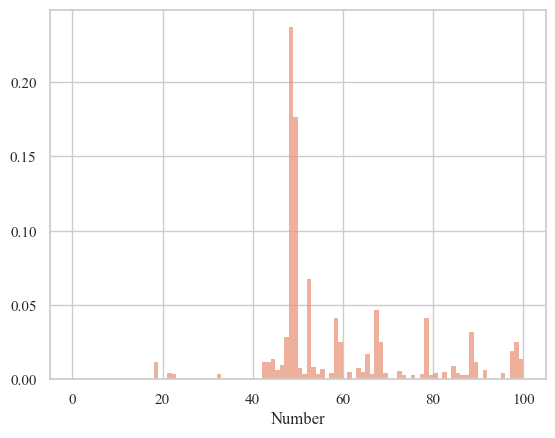

In [47]:
plot_distribution(
    dist_vanilla,
    n_max=n_max,
    model_name="Vanilla Model",
    color="darksalmon",
    xlims=(-5, 105),
    number_of_NaNs=number_of_NaNs_vanilla,
)

In [49]:
if not os.path.exists("plots"):
    os.makedirs("plots")

df_inference = pd.DataFrame(dist_inference, columns=["Generated Numbers"])
df_inference.to_csv(
    f"plots/GFN_nb-numbers_{number_of_numbers}_nb-NaNs_{number_of_NaNs_inference}_{ckpt_name}.csv",
    index=False,
)

df_vanilla = pd.DataFrame(dist_vanilla, columns=["Generated Numbers"])
df_vanilla.to_csv(
    f"plots/Vanilla_nb-numbers_{number_of_numbers_vanilla}_nb-NaNs_{number_of_NaNs_vanilla}_{ckpt_name}.csv",
    index=False,
)

In [50]:
print(
    f"plots/Vanilla_nb-numbers_{number_of_numbers_vanilla}_nb-NaNs_{number_of_NaNs_vanilla}_{ckpt_name}.csv"
)
print(
    f"plots/GFN_nb-numbers_{number_of_numbers}_nb-NaNs_{number_of_NaNs_inference}_{ckpt_name}.csv"
)

plots/Vanilla_nb-numbers_498561_nb-NaNs_13439_rng-GFN_gpt-j_bsz_8_grad_acc_8_lr_0.0005_warmup_steps_10_total_steps_2560_subtb_lambda_1.0_max_len_5_min_len_1_eval_interval_100_log_interval_10_seed_42.csv
plots/GFN_nb-numbers_512000_nb-NaNs_0_rng-GFN_gpt-j_bsz_8_grad_acc_8_lr_0.0005_warmup_steps_10_total_steps_2560_subtb_lambda_1.0_max_len_5_min_len_1_eval_interval_100_log_interval_10_seed_42.csv


[]

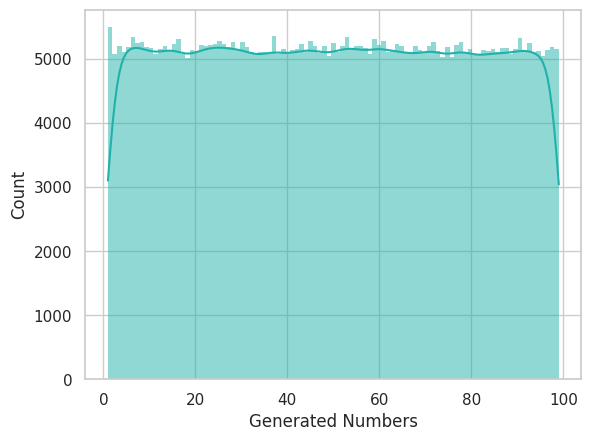

In [55]:
# Count the values with Counter
from collections import Counter

Counter(df_inference["Generated Numbers"].to_list())

# Plot
sns.set_theme(style="whitegrid")
plot = sns.histplot(
    df_inference["Generated Numbers"],
    kde=True,
    color="lightseagreen",
    linewidth=0,
    bins=n_max - 1,
)

plt.plot()

<Axes: title={'center': 'Distribution of generated numbers between 0 and 100 (512000 samples)'}, xlabel='Number', ylabel='Count'>

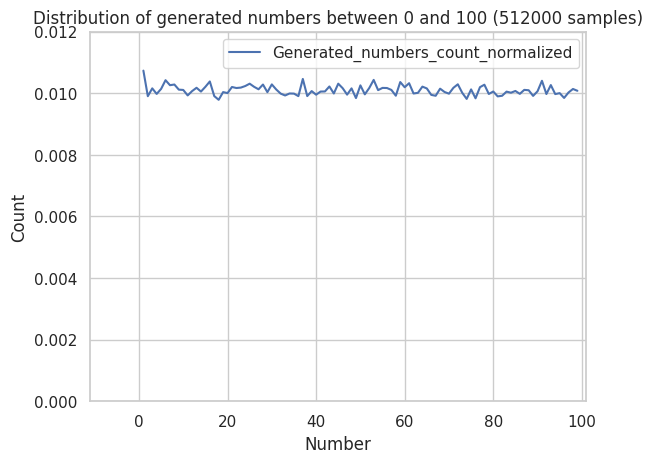

In [53]:
def clean_data(df_inference):
    # Performed 1 aggregation grouped on column: 'Generated Numbers'
    df_inference = (
        df_inference.groupby(["Generated Numbers"])
        .agg(Generated_numbers_count=("Generated Numbers", "count"))
        .reset_index()
    )

    # Normalize Generated_numbers_count into Generated_numbers_count_normalized
    df_inference["Generated_numbers_count_normalized"] = (
        df_inference["Generated_numbers_count"]
        / df_inference["Generated_numbers_count"].sum()
    )

    return df_inference


df_inference_clean = clean_data(df_inference.copy())

df_inference_clean.plot(
    x="Generated Numbers",
    y="Generated_numbers_count_normalized",
    kind="line",
    title=f"Distribution of generated numbers between 0 and {n_max} ({len(dist_inference)} samples)",
    xlabel="Number",
    ylabel="Count",
    xlim=(-11, 101),
    ylim=(0, 0.012),
)